# Precision analysis
This notebook demonstrates the effect of the relative error tolerance.

In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qiskit.providers.aer.noise import NoiseModel
from qaoa import *
from pylab import cm

from matplotlib import rc,patches
from scipy import optimize as opt

# Parameters when sampling the entire parameter space
SAMPLING_E_ATOL = 2e-2
SAMPLING_E_RTOL = 1e-2
SAMPLING_DELTA_V_RTOL = 1e-1
MIN_SAMPLES = 64
MAX_SAMPLES = 32768*16
SAMPLING_CONF_IDX = 1
LANDSCAPE_RESOLUTION = 16

# Parameters for error tolerance iterations
N_INITIAL_GAMMA = 5
N_INITIAL_BETA = 3
N_REPS = 8
MIN_E_RTOL = 2e-1
MAX_E_RTOL = 4e-3
N_E_RTOL = 6
N_INITIAL_POINTS = N_INITIAL_GAMMA * N_INITIAL_BETA

# Other parameters
WEIGHT_DECIMALS = 0
CIRCUIT_VERSION = 1
CIRCUIT_DEPTH = 1

font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

100%
Max cost: 5


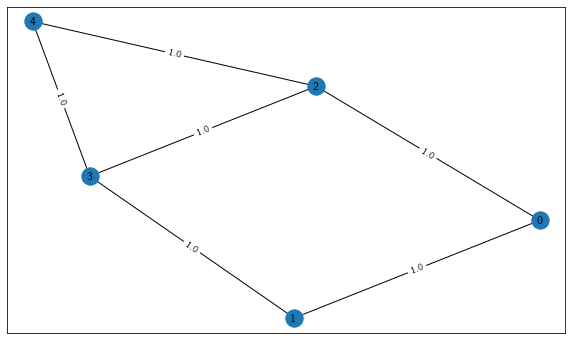

In [2]:
V = np.arange(0,5,1)
E =[(0,1),(0,2),(2,3),(3,1),(3,4),(4,2)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)
addWeights_MaxCut(G,decimals=WEIGHT_DECIMALS)

pl.figure(figsize=(10,6))
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx(G,pos)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

V1 = np.arange(0,)
costs=costsHist_MaxCut(G)
max_cost = max(costs)
print('Max cost: %d' % max_cost)

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')

Now we sample the entire parameter space landscape and find the cost value at each point.

In [4]:
(gamma_min,gamma_max),(beta_min,beta_max) = parameterBounds_MaxCut(G,decimals=WEIGHT_DECIMALS)
gamma_period = (gamma_max-gamma_min)*2
beta_period = beta_max-beta_min

# Use the weights to find the typical Fourier frequency. Then pick LANDSCAPE_RESOLUTION points
# within each sinusoid oscillation at this frequency.
max_weight = max([w for _,_,w in G.edges.data('weight',default=1)])
landscape_n_gamma = int(LANDSCAPE_RESOLUTION*np.ceil(gamma_period*(max_weight/2)/(2*np.pi)))
landscape_n_beta = int(LANDSCAPE_RESOLUTION*np.ceil(beta_period/(2*np.pi)))

print('landscape_n_gamma: %d' % landscape_n_gamma)
print('landscape_n_beta: %d' % landscape_n_beta)

gammas_landscape = np.linspace(gamma_min,gamma_max,landscape_n_gamma)
betas_landscape = np.linspace(beta_min,beta_max,landscape_n_beta)

E_landscape = np.zeros((landscape_n_beta,landscape_n_gamma))
circuits=[]
for i in range(landscape_n_beta):
    for j in range(landscape_n_gamma):
        beta = betas_landscape[i]
        gamma = gammas_landscape[j]
        circuit = createCircuit_MaxCut(np.array((gamma,beta)),G,CIRCUIT_DEPTH,CIRCUIT_VERSION)
        [E_list,_,_] = sampleUntilPrecision_MaxCut(circuit,G,backend_sim,None,MIN_SAMPLES,
                                                             MAX_SAMPLES,SAMPLING_E_ATOL,SAMPLING_E_RTOL,
                                                             SAMPLING_DELTA_V_RTOL,SAMPLING_CONF_IDX)
        E_landscape[i,j] = E_list[-1]
        print('%.2f%%' % ((i*landscape_n_gamma+j)*100/(landscape_n_gamma*landscape_n_beta)),end='\r')
        

landscape_n_gamma: 16
landscape_n_beta: 16


Prepare the initial points from which we will do the optimizations.

In [5]:
delta_gamma = (gamma_max-gamma_min)/N_INITIAL_GAMMA
delta_beta = (beta_max-beta_min)/N_INITIAL_BETA

initial_points = np.mgrid[gamma_min+delta_gamma/2:gamma_max-delta_gamma/2:N_INITIAL_GAMMA*1j,
                          beta_min+delta_beta/2:beta_max-delta_beta/2:N_INITIAL_BETA*1j]
initial_gammas = initial_points[0,:].flatten()
initial_betas = initial_points[1,:].flatten()

Text(0.5, 1.0, 'Optimization landscape')

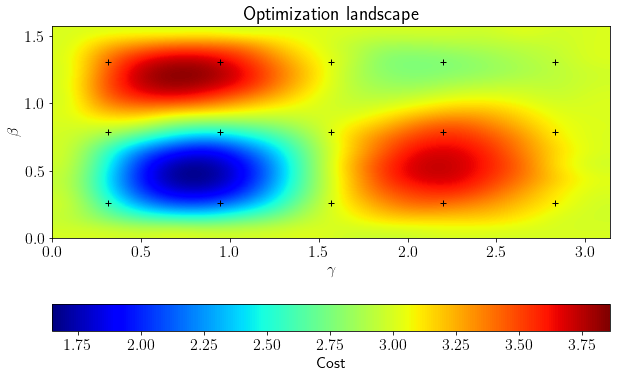

In [6]:
pl.figure(figsize=(10,6))
pl.imshow(np.array(E_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='bicubic',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
pl.plot(initial_gammas,initial_betas,'k+')
cbar = pl.colorbar(orientation="horizontal", pad=0.2)
cbar.set_label('Cost')

pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Optimization landscape')

Now we iterate over each of **N_E_RTOL** error tolerances. For each of them, do **N_REPS** optimization runs at each of the **N_INITIAL_POINTS** parameters space lattice points.

In [7]:
def getval(x,history_ref,backend,depth,version,noisemodel,E_atol,E_rtol,dv_rtol,min_n_shots,max_n_shots,conf_idx):
    circuit = createCircuit_MaxCut(x,G,depth,version)
    
    [E_list,v_list,n_list] = sampleUntilPrecision_MaxCut(circuit,G,backend,noisemodel,min_n_shots,
                                                         max_n_shots,E_atol,E_rtol,dv_rtol,conf_idx)

    history_ref['gammas'].append(x[0])
    history_ref['betas'].append(x[1])
    history_ref['expectations'].append(E_list)
    history_ref['variances'].append(v_list)
    history_ref['n_shots'].append(n_list)
        
    return -E_list[-1]

In [8]:
E_rtols = np.geomspace(MIN_E_RTOL,MAX_E_RTOL,N_E_RTOL)
E_atol = np.inf

opt_histories = []
for i in range(N_E_RTOL):
    E_rtol = E_rtols[i]

    opt_histories.append([])
    for j in range(N_INITIAL_POINTS):
        x0 = (initial_gammas[j],initial_betas[j])
        
        opt_histories[i].append([])
        for k in range(N_REPS):
        
            opt_history = {
                'gammas': [],
                'betas': [],
                'expectations': [],
                'variances': [],
                'n_shots': [],
            }
            opt.minimize(getval, x0=x0, method='COBYLA',
                             args=(opt_history,backend_sim,CIRCUIT_DEPTH,CIRCUIT_VERSION,None,
                                   E_atol,E_rtol,SAMPLING_DELTA_V_RTOL,
                                   MIN_SAMPLES,MAX_SAMPLES,SAMPLING_CONF_IDX),
                             options={'rhobeg': 1e0, 'disp': True, 'maxiter': 10000})
            
            opt_histories[i][j].append(opt_history)
            print('%.2f%%/%.2f%%/%.2f%%' % (i*100/N_E_RTOL,j*100/N_INITIAL_POINTS,k*100/N_REPS),end='\r')
            
        


Let us verify that the optimizations seem to work correctly.

Text(0.5, 1.0, 'Optimization landscape')

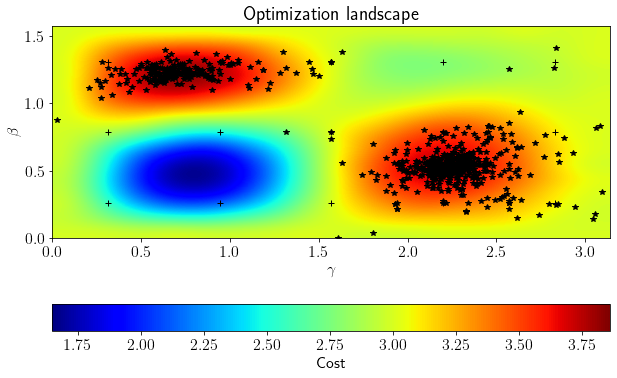

In [9]:
pl.figure(figsize=(10,6))
pl.imshow(np.array(E_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='bicubic',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])

for j in range(N_INITIAL_POINTS):
    for i in range(N_E_RTOL):
        for k in range(N_REPS):
            gammas = list(opt_history['gammas'])
            betas = list(opt_history['betas'])
            for it in range(len(gammas)):
                gammas[it],betas[it] = wrapParameters_MaxCut(gammas[it],betas[it],
                                                             (gamma_min,gamma_max),
                                                             (beta_min,beta_max))
            opt_history = opt_histories[i][j][k]
            pl.plot(gammas[-1],betas[-1],'k*',linewidth=0.3)
    pl.plot(initial_gammas[j],initial_betas[j],'k+')

cbar = pl.colorbar(orientation="horizontal", pad=0.2)
cbar.set_label('Cost')

pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Optimization landscape')

Finally we plot histograms for the achieved optimization ratios, as well as iterations and total shots per optimization.

<Figure size 432x288 with 0 Axes>

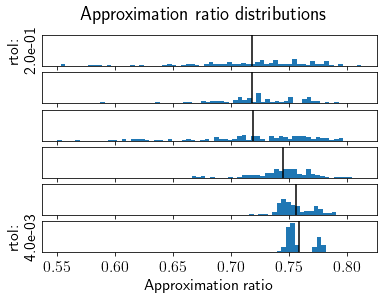

<Figure size 432x288 with 0 Axes>

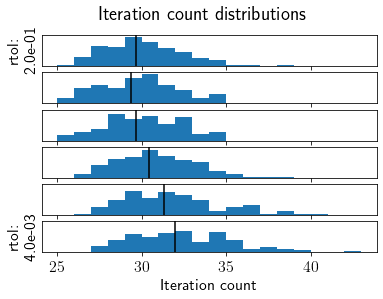

<Figure size 432x288 with 0 Axes>

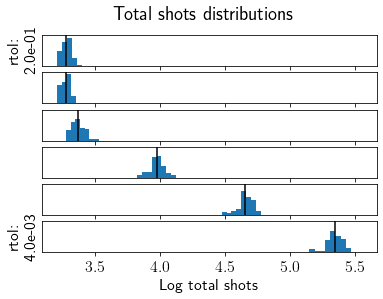

In [10]:
n_datapoints = N_REPS*N_INITIAL_POINTS

apx_ratios = np.zeros((N_E_RTOL,n_datapoints))
n_itss = np.zeros((N_E_RTOL,n_datapoints))
n_shotss = np.zeros((N_E_RTOL,n_datapoints))


for i in range(N_E_RTOL):
    for j in range(N_INITIAL_POINTS):
        for k in range(N_REPS):
            opt_history = opt_histories[i][j][k]
            
            n_shots_list = [sum(x) for x in opt_history['n_shots']]
            E = opt_history['expectations'][-1]
            
            tot_n_shots = sum(n_shots_list)
            n_its = len(n_shots_list)
            apx_ratio = E[-1]/max_cost

            flat_idx = j*N_REPS + k
            apx_ratios[i,flat_idx] = apx_ratio
            n_itss[i,flat_idx] = n_its
            n_shotss[i,flat_idx] = tot_n_shots
            
pl.figure()
_,axs = pl.subplots(N_E_RTOL,1,sharex=True,sharey='col')
for i in range(N_E_RTOL):
    binsize = 0.004
    apx_ratios_flat = apx_ratios[i].flatten()
    n_bins = int(np.ceil((max(apx_ratios_flat)-min(apx_ratios_flat))/binsize))
    
    axs[i].hist(apx_ratios_flat,n_bins,label='Distribution, E_rtol=%.2e'%E_rtols[i])
    axs[i].axvline(np.average(apx_ratios_flat),color='k')
    if i in [0, N_E_RTOL-1]:
        axs[i].set_ylabel('rtol:\n%.1e' % E_rtols[i])
    axs[i].set_yticks([])
pl.xlabel('Approximation ratio')
pl.suptitle('Approximation ratio distributions')
pl.savefig('rtol_E_pdf.svg')

pl.figure()
_,axs = pl.subplots(N_E_RTOL,1,sharex=True,sharey='col')
for i in range(N_E_RTOL):
    binsize = 1
    n_its_flat = n_itss[i].flatten()
    n_bins = int(np.ceil((max(n_its_flat)-min(n_its_flat))/binsize))
    
    axs[i].hist(n_its_flat,n_bins,label='Distribution, E_rtol=%.2e'%E_rtols[i])
    axs[i].axvline(np.average(n_its_flat),color='k')
    if i in [0, N_E_RTOL-1]:
        axs[i].set_ylabel('rtol:\n%.1e' % E_rtols[i])
    axs[i].set_yticks([])
pl.xlabel('Iteration count')
pl.suptitle('Iteration count distributions')
pl.savefig('rtol_its_pdf.svg')

pl.figure()
_,axs = pl.subplots(N_E_RTOL,1,sharex=True,sharey='col')
for i in range(N_E_RTOL):
    binsize = 0.04
    n_shots_flat = np.log10(n_shotss[i].flatten())
    n_bins = int(np.ceil((max(n_shots_flat)-min(n_shots_flat))/binsize))
    
    axs[i].hist(n_shots_flat,n_bins,label='Distribution, E_rtol=%.2e'%E_rtols[i])
    axs[i].axvline(np.average(n_shots_flat),color='k')
    if i in [0, N_E_RTOL-1]:
        axs[i].set_ylabel('rtol:\n%.1e' % E_rtols[i])
    axs[i].set_yticks([])
pl.xlabel('Log total shots')
pl.suptitle('Total shots distributions')
pl.savefig('rtol_shots_pdf.svg')